In [62]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


In [6]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
print(device)

cuda


In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST("data", transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

In [21]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(torch.nn.Linear(28*28, 500),
                                    torch.nn.LeakyReLU(0.2),
                                    torch.nn.Linear(500, 200),
                                    torch.nn.LeakyReLU(0.2),
                                    torch.nn.Linear(200, 10),
                                    torch.nn.Sigmoid())
        
    def forward(self, x):
        return self.net(x)
    

In [13]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, 500)
        self.fc2 = torch.nn.Linear(500, 200)
        self.fc3 = torch.nn.Linear(200, 1)
        
        self.activation = torch.nn.LeakyReLU(0.2)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [28]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(50, 200)
        self.fc2 = torch.nn.Linear(200, 500)
        self.fc3 = torch.nn.Linear(500, 28*28)
        
        self.activation = torch.nn.LeakyReLU(0.2)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x

In [325]:
disc = Discriminator().to(device)
gen = Generator().to(device)
clafi = Classifier().to(device)

In [343]:
test_noise = torch.tensor(np.random.normal(0, 1, size=(50)), dtype=torch.float).to(device)
generated_img = gen(test_noise)
numpy_generated_img = generated_img.view(28, 28).cpu().detach().numpy()

0.7862238883972168
3


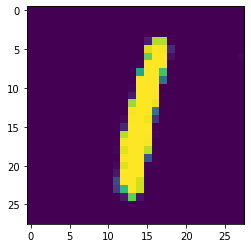

In [344]:
print(disc(generated_img).cpu().detach().item())
print(torch.argmax(clafi(generated_img).cpu().detach()).item())
plt.imshow(numpy_generated_img)

In [328]:
epochs = 30
batch_size=32

In [329]:
gen_lr = 3e-4
disc_lr = 3e-4
clafi_lr = 3e-4

In [330]:
mce_loss = torch.nn.CrossEntropyLoss()
bce_loss = torch.nn.BCELoss()

gen_optim = torch.optim.Adam(gen.parameters(), lr=gen_lr)
disc_optim = torch.optim.Adam(disc.parameters(), lr=disc_lr)
clafi_lr = torch.optim.Adam(clafi.parameters(), lr=clafi_lr)

In [331]:
real_output = torch.ones(batch_size, dtype=torch.float).to(device)
fake_output = torch.zeros(batch_size, dtype=torch.float).to(device)

In [332]:
for e in tqdm(range(epochs)):
    for i, b in enumerate(trainloader):
        mnist_img = b[0].view(-1, 28*28).to(device)
        labels = b[1].to(device)
        noise = torch.tensor(np.random.normal(0, 1, size=(batch_size, 50)), dtype=torch.float).to(device)
        
        #generated_img = gen(noise)
        
        if i % 1 == 0:
            gen_loss = bce_loss(disc(gen(noise)).view(batch_size), real_output)
            gen_optim.zero_grad()
            gen_loss.backward()
            gen_optim.step()
        
        disc_loss = bce_loss(disc(gen(noise)).view(batch_size), fake_output)
        disc_loss += bce_loss(disc(mnist_img).view(batch_size), real_output)
        
        disc_optim.zero_grad()
        disc_loss.backward()
        disc_optim.step()

100%|██████████████████████████████████████████| 30/30 [11:33<00:00, 23.13s/it]
